In [1]:
%matplotlib inline

In [2]:
# import all necessary libraries
import pandas as pd
import numpy as np
import matplotlib as mp
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import LabelEncoder
from pandas.plotting import scatter_matrix

In [4]:
modbus = pd.read_csv("/Train_Test_IoT_Modbus.csv")

In [5]:
modbus.head()

,ts,date,time,FC1_Read_Input_Register,FC2_Read_Discrete_Value,FC3_Read_Holding_Register,FC4_Read_Coil,label,type
0,1556208840,25-Apr-19,09:14:00,49389,52921,25770,13625,1,injection
1,1556208840,25-Apr-19,09:14:00,49389,52921,25770,13625,1,injection
2,1556208841,25-Apr-19,09:14:01,49389,52921,25770,13625,1,injection
3,1556208842,25-Apr-19,09:14:02,49389,52921,25770,13625,1,injection
4,1556208844,25-Apr-19,09:14:04,40665,44748,21098,35371,1,injection


In [6]:
modbus.drop(columns=['ts','date', 'time', 'label'],inplace=True)

In [7]:
modbus.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51106 entries, 0 to 51105
Data columns (total 5 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   FC1_Read_Input_Register    51106 non-null  int64 
 1   FC2_Read_Discrete_Value    51106 non-null  int64 
 2   FC3_Read_Holding_Register  51106 non-null  int64 
 3   FC4_Read_Coil              51106 non-null  int64 
 4   type                       51106 non-null  object
dtypes: int64(4), object(1)
memory usage: 1.9+ MB


In [8]:
modbus['type'].value_counts()

normal       35000
injection     5000
password      5000
backdoor      5000
xss            577
scanning       529
Name: type, dtype: int64

In [9]:
label_type = LabelEncoder()
modbus['type']=label_type.fit_transform(modbus['type'])

In [10]:
modbus['type'].value_counts()

2    35000
3     5000
1     5000
0     5000
5      577
4      529
Name: type, dtype: int64

In [11]:
modbus.isnull().sum()

FC1_Read_Input_Register      0
FC2_Read_Discrete_Value      0
FC3_Read_Holding_Register    0
FC4_Read_Coil                0
type                         0
dtype: int64

In [12]:
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)
for train_index, test_index in split.split(modbus, modbus['type']):
  strat_train = modbus.loc[train_index]
  strat_test = modbus.loc[test_index]

In [13]:
modbus = strat_train.copy()

In [14]:
modbus.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35774 entries, 48273 to 26801
Data columns (total 5 columns):
 #   Column                     Non-Null Count  Dtype
---  ------                     --------------  -----
 0   FC1_Read_Input_Register    35774 non-null  int64
 1   FC2_Read_Discrete_Value    35774 non-null  int64
 2   FC3_Read_Holding_Register  35774 non-null  int64
 3   FC4_Read_Coil              35774 non-null  int64
 4   type                       35774 non-null  int64
dtypes: int64(5)
memory usage: 1.6 MB


In [15]:
##pipeline creation

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
my_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),
    ('std_scaler', StandardScaler()),
])

In [16]:
X_train=modbus.drop("type", axis = 1)
Y_train=modbus['type'].copy()
X_test = strat_test.drop("type",axis = 1)
Y_test = strat_test['type'].copy()

In [17]:
X_train = my_pipe.fit_transform(X_train)
X_test = my_pipe.fit_transform(X_test)

# add rus here

In [22]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn import metrics
#import for normalize, cross val, kfold, randomsearch
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import RandomizedSearchCV

##n_estimators is number of weak learners to train iteratively
##learning_rate is weight of weak learners
abcMod = AdaBoostClassifier(n_estimators = 50, random_state=1)
cv = KFold(n_splits=10, shuffle=True, random_state=1)
n_scores=cross_val_score(abcMod, X_train, Y_train, scoring='accuracy', cv=cv, n_jobs=1, error_score='raise')
print('Accuracy: %3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

Accuracy: 0.684380 (0.006)


In [19]:
abcMod.fit(X_train, Y_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=1)

In [20]:
y_pred = abcMod.predict(X_test)

In [21]:
print(metrics.classification_report(Y_test,y_pred))

              precision    recall  f1-score   support

           0       0.36      0.01      0.01      1500
           1       0.00      0.00      0.00      1500
           2       0.69      1.00      0.81     10500
           3       0.00      0.00      0.00      1500
           4       0.00      0.00      0.00       159
           5       0.00      0.00      0.00       173

    accuracy                           0.68     15332
   macro avg       0.17      0.17      0.14     15332
weighted avg       0.50      0.68      0.56     15332



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


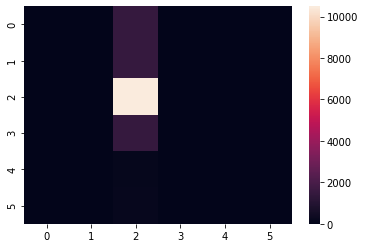

In [24]:
cm = metrics.confusion_matrix(Y_test, y_pred)
import seaborn as sns
sns.heatmap(cm)

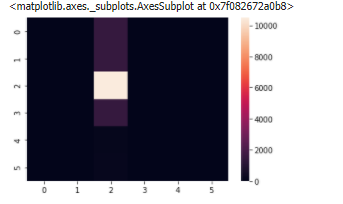

## **Hyper Parameter Tuning**

In [23]:
parameters = {"learning_rate":[0.1,0.01,0.001],
              "n_estimators":[100,250,500,1000]}
search = RandomizedSearchCV(abcMod, param_distributions=parameters, scoring='accuracy', cv=10,
                            verbose=3, random_state=42)

In [ ]:
model_abc = search.fit(X_train, Y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits
[CV] n_estimators=500, learning_rate=0.001 ...........................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_estimators=500, learning_rate=0.001, score=0.685, total=  15.6s
[CV] n_estimators=500, learning_rate=0.001 ...........................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   15.6s remaining:    0.0s


[CV]  n_estimators=500, learning_rate=0.001, score=0.685, total=  15.9s
[CV] n_estimators=500, learning_rate=0.001 ...........................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   31.5s remaining:    0.0s


[CV]  n_estimators=500, learning_rate=0.001, score=0.685, total=  15.8s
[CV] n_estimators=500, learning_rate=0.001 ...........................
[CV]  n_estimators=500, learning_rate=0.001, score=0.685, total=  15.7s
[CV] n_estimators=500, learning_rate=0.001 ...........................
[CV]  n_estimators=500, learning_rate=0.001, score=0.685, total=  15.7s
[CV] n_estimators=500, learning_rate=0.001 ...........................
[CV]  n_estimators=500, learning_rate=0.001, score=0.685, total=  15.7s
[CV] n_estimators=500, learning_rate=0.001 ...........................
[CV]  n_estimators=500, learning_rate=0.001, score=0.685, total=  15.6s
[CV] n_estimators=500, learning_rate=0.001 ...........................
[CV]  n_estimators=500, learning_rate=0.001, score=0.685, total=  15.7s
[CV] n_estimators=500, learning_rate=0.001 ...........................
[CV]  n_estimators=500, learning_rate=0.001, score=0.685, total=  15.7s
[CV] n_estimators=500, learning_rate=0.001 ...........................

In [ ]:
abc_final = AdaBoostClassifier(random_state=42, n_estimators=model_abc.best_params_['n_estimators'],learning_rate=model_abc.best_params_['learning_rate'])
abc_final.fit(X_train, Y_train)

y_pred1 = abc_final.predict(X_test)

In [ ]:
print(metrics.classification_report(Y_test, y_pred1))